In [54]:
# Read in Data

In [55]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import re
import string

import tensorflow as tf

nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords 
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
data = pd.read_csv('text_emotion.csv')
data

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


array([8638, 8459, 5209, 5165, 3842, 2187, 1776, 1526, 1323,  827,  759,
        179,  110], dtype=int64)

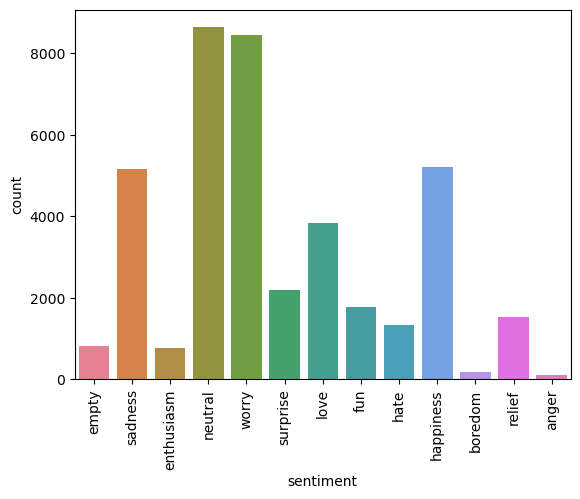

In [57]:
sns.countplot(x='sentiment', data=data, hue='sentiment')
plt.xticks(rotation=90)
labs = data['sentiment'].value_counts().values
labs

In [58]:
negative = data.sentiment.str.contains('sadness|worry|hate|boredom|empty|anger', case = False, regex = True)
positive = data.sentiment.str.contains('enthusiasm|surprise|love|fun|happiness|relief', case = False, regex=True)
neutral = data.sentiment.str.contains('neutral', case = False, regex = True)

print(positive)

0        False
1        False
2        False
3         True
4        False
         ...  
39995    False
39996     True
39997     True
39998     True
39999     True
Name: sentiment, Length: 40000, dtype: bool


In [59]:
data.loc[positive, 'sentiment'] = 'positive'
data.loc[negative, 'sentiment'] = 'negative'
data.loc[neutral, 'sentiment'] = 'neutral'

data.sentiment.value_counts()

sentiment
negative    16063
positive    15299
neutral      8638
Name: count, dtype: int64

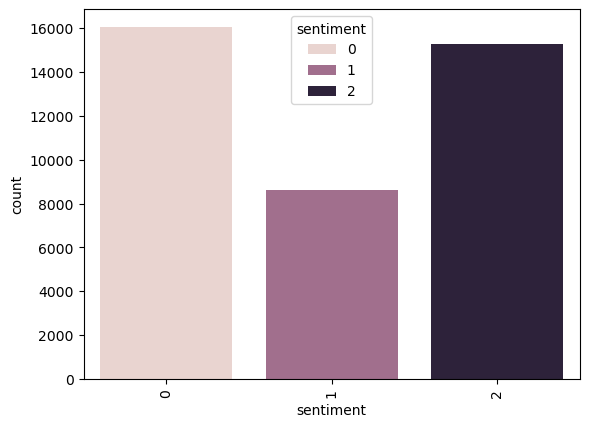

In [60]:
sentiment_encoder = LabelEncoder()
data.sentiment = sentiment_encoder.fit_transform(data.sentiment)
sns.countplot(x ='sentiment', data = data, hue='sentiment')
plt.xticks(rotation = 90);

In [61]:
# Process Tweet Data

In [62]:
STOPWORDS = stopwords.words('english')
PUNCTUTATIONS = string.punctuation

def clean_text(t):

    new_text = str(t.lower())

    trans = str.maketrans('', '', PUNCTUTATIONS)
    new_text= new_text.translate(trans)

    new_text = ' '.join([word for word in new_text.split() if word not in STOPWORDS])

    new_text = re.sub(r'(.)1+', r'1', new_text)

    # Remove URLs
    new_text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',new_text)

    # Remove numbers
    new_text = re.sub('[0-9]+', '', new_text)

    word_tokens = text_to_word_sequence(new_text)

    # Get Stemm from each word
    # For example, “Drove” and “Driving” should both be reduced to their stem “Drive”
    st = nltk.PorterStemmer()
    word_tokens = [st.stem(w) for w in word_tokens]

    return word_tokens

data['content'] = data['content'].apply(clean_text)
data['content'].head()



0    [tiffanylu, know, listenin, bad, habit, earlie...
1         [layin, n, bed, headach, ughhhhwaitin, call]
2                      [funer, ceremonygloomi, friday]
3                           [want, hang, friend, soon]
4    [dannycastillo, want, trade, someon, houston, ...
Name: content, dtype: object

In [63]:
# Get Vocabulary from Tweets

In [64]:
tweets_ls = data['content'].to_numpy()
all_words = [word for words_ls in tweets_ls for word in words_ls]

all_words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_words)
tokens = tokenizer.word_index

vocabulary_size = len(tokens)

In [65]:
# Build Sequences of Tokens

In [66]:
max_seq = data['content'].str.len().max()

sequences = tokenizer.texts_to_sequences(tweets_ls)
sequences = pad_sequences(sequences, maxlen=max_seq, padding='pre')
sequences

array([[    0,     0,     0, ...,    84,   986,   373],
       [    0,     0,     0, ...,   308, 12176,    93],
       [    0,     0,     0, ...,  1956, 12177,   149],
       ...,
       [    0,     0,     0, ...,   947,   164,     2],
       [    0,     0,     0, ...,   849,    23,   275],
       [    0,     0,     0, ..., 45322, 45323, 45324]])

In [67]:
print(sequences[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0 12175    17  2674    64  3416   680    84   986
   373]


In [68]:
X = sequences
y = data[['sentiment']].to_numpy().ravel()

In [69]:
# Build Model

In [70]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=0)

In [71]:
print(y_train.shape)

(22400,)


In [72]:
# Define architecture
model=Sequential()
#model.add(Input(shape=(max_tweet_length,)))

model.add(Embedding(input_dim=vocabulary_size+1, 
                    output_dim=5,
                    input_length=max_seq,
                     embeddings_regularizer=regularizers.L2(0.01),
                     embeddings_constraint=None))

model.add(LSTM(100, kernel_regularizer=regularizers.L2(0.01),recurrent_regularizer=regularizers.L2(1)))
# #model.add(LSTM(200))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

# # Hidden layer
# model.add(Dense(units=20, 
#                 activation='relu', 
#                 kernel_initializer='uniform', 
#                 kernel_regularizer=regularizers.L2(0.1), 
#                 bias_regularizer=regularizers.L2(0.1), 
#                 activity_regularizer=regularizers.L2(0.1)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))


# Compile NN
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 5)             226625    
                                                                 
 lstm_2 (LSTM)               (None, 100)               42400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 269,328
Trainable params: 269,328
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 5)             226625    
                                                                 
 lstm_2 (LSTM)               (None, 100)               42400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 269,328
Trainable params: 269,328
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[],
                    verbose=1)

Epoch 1/100
700/700 [==============================] - 6s 7ms/step - loss: 5.4417 - accuracy: 0.3971 - val_loss: 1.0637 - val_accuracy: 0.4054
Epoch 2/100
700/700 [==============================] - 5s 6ms/step - loss: 1.0664 - accuracy: 0.3970 - val_loss: 1.0641 - val_accuracy: 0.4054
Epoch 3/100
700/700 [==============================] - 5s 6ms/step - loss: 1.0656 - accuracy: 0.4020 - val_loss: 1.0618 - val_accuracy: 0.4000
Epoch 4/100
700/700 [==============================] - 5s 7ms/step - loss: 1.0641 - accuracy: 0.4039 - val_loss: 1.0648 - val_accuracy: 0.4002
Epoch 5/100
700/700 [==============================] - 5s 6ms/step - loss: 1.0637 - accuracy: 0.4071 - val_loss: 1.0620 - val_accuracy: 0.3980
Epoch 6/100
700/700 [==============================] - 5s 7ms/step - loss: 1.0619 - accuracy: 0.4107 - val_loss: 1.0596 - val_accuracy: 0.4080
Epoch 7/100
700/700 [==============================] - 5s 6ms/step - loss: 1.0625 - accuracy: 0.4126 - val_loss: 1.0601 - val_accuracy: 0.4146

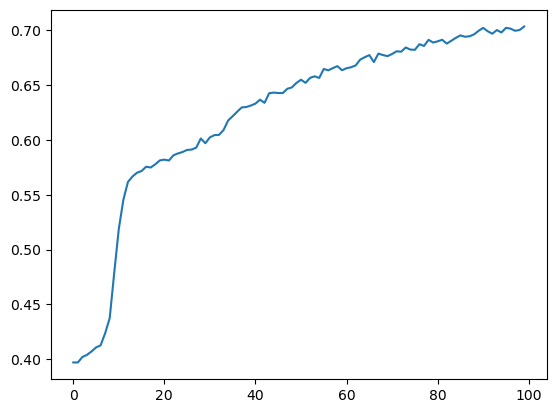

In [75]:
plt.plot(history.history['accuracy'])

In [76]:
model.evaluate(X_test, y_test)

375/375 [==============================] - 1s 3ms/step - loss: 1.1922 - accuracy: 0.5517


[1.1922060251235962, 0.5516666769981384]